In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycwt as wavelet
from scipy import signal
import yfinance as yf

import warnings

warnings.filterwarnings('ignore')

# data preprocessing 

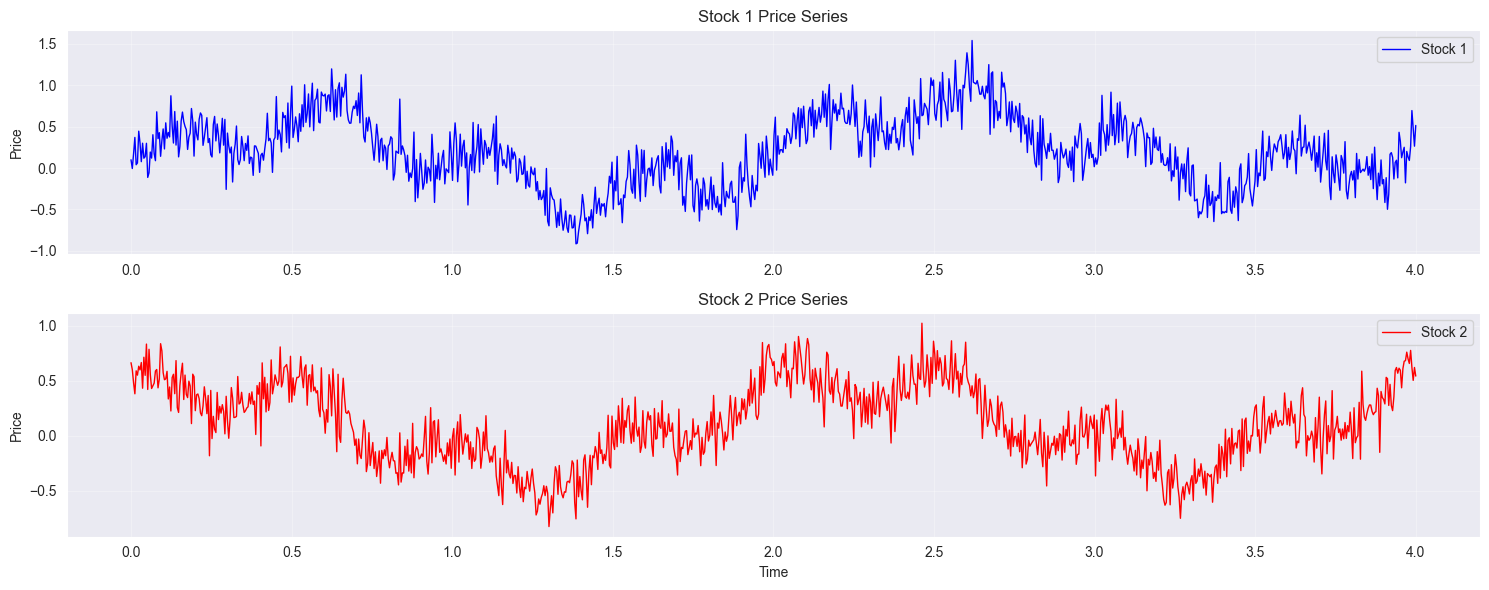

In [2]:
def apply_to_real_stock_data():

    # 두 주식의 데이터 다운로드
    stock1_data = yf.download('005930.KS', start='2020-01-01', end='2023-01-01')  # 삼성전자
    stock2_data = yf.download('000660.KS', start='2020-01-01', end='2023-01-01')  # SK하이닉스

    # 종가 데이터 추출
    stock1_close = stock1_data['Close'].values
    stock2_close = stock2_data['Close'].values
    time_real = np.arange(len(stock1_close))

    # 로그 수익률 계산
    stock1_returns = np.log(stock1_close[1:] / stock1_close[:-1])
    stock2_returns = np.log(stock2_close[1:] / stock2_close[:-1])

    # 웨이브렛 분석 적용
    power1_real, period1_real, coi1_real, W1_real = calculate_individual_wavelet_spectrum(
        stock1_returns, dt=1.0
    )
    power2_real, period2_real, coi2_real, W2_real = calculate_individual_wavelet_spectrum(
        stock2_returns, dt=1.0
    )
    

apply_to_real_stock_data()

# 데이터 시각화
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(time, stock1, 'b-', label='Stock 1', linewidth=1)
plt.title('Stock 1 Price Series')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(time, stock2, 'r-', label='Stock 2', linewidth=1)
plt.title('Stock 2 Price Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# individual_wavelet_spectrum

In [ ]:
def calculate_individual_wavelet_spectrum(signal, dt=1.0, dj=1/12, s0=None, J=None, 
                                        wavelet_type='morlet'):
    """
    개별 신호의 웨이브렛 스펙트럼 계산
    
    Parameters:
    -----------
    signal : array-like
        분석할 시계열 데이터
    dt : float
        샘플링 간격
    dj : float
        스케일 해상도
    s0 : float
        최소 스케일
    J : int
        스케일 개수
    wavelet_type : str
        웨이브렛 타입
    
    Returns:
    --------
    power : ndarray
        웨이브렛 파워 스펙트럼
    period : ndarray
        주기 배열
    coi : ndarray
        Cone of influence
    """
    
    # 웨이브렛 선택
    if wavelet_type.lower() == 'morlet':
        mother = wavelet.Morlet(6)
    else:
        mother = wavelet.Morlet(6)
    
    # 기본 파라미터 설정
    if s0 is None:
        s0 = 2 * dt
    if J is None:
        J = int(np.log2(len(signal) * dt / s0) / dj)
    
    # 연속 웨이브렛 변환 수행
    W, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
        signal, dt, dj=dj, s0=s0, J=J, wavelet=mother
    )
    
    # 파워 스펙트럼 계산
    power = (np.abs(W)) ** 2
    period = 1 / freqs
    
    return power, period, coi, W

def plot_individual_wavelet_spectrum(time, period, power, coi, title="Wavelet Spectrum"):
    """
    개별 웨이브렛 스펙트럼 시각화
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # 시간-주기 범위 설정
    extent = [time.min(), time.max(), np.log2(period.min()), np.log2(period.max())]
    
    # 파워 스펙트럼 플롯 (로그 스케일)
    im = ax.imshow(np.log2(power), extent=extent, cmap='jet', aspect='auto', 
                   origin='lower')
    
    # Cone of influence 표시
    ax.plot(time, np.log2(coi), 'k--', linewidth=2, label='Cone of Influence')
    
    # 컬러바 추가
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Power (log₂)', fontsize=12)
    
    # 축 레이블 및 제목
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('log₂(Period)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Y축 눈금 설정
    yticks = np.arange(np.ceil(np.log2(period.min())), 
                      np.floor(np.log2(period.max())) + 1)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{2**int(y)}' for y in yticks])
    
    # 범례 추가
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

time, stock1, stock2 = generate_sample_data()
dt = time[1] - time[0]

# 각 주식의 웨이브렛 스펙트럼 계산
power1, period1, coi1, W1 = calculate_individual_wavelet_spectrum(stock1, dt=dt)
power2, period2, coi2, W2 = calculate_individual_wavelet_spectrum(stock2, dt=dt)

print(f"Stock 1 - Wavelet spectrum shape: {power1.shape}")
print(f"Stock 2 - Wavelet spectrum shape: {power2.shape}")
print(f"Period range: {period1.min():.4f} - {period1.max():.4f}")

# wavelet coherence calculation

In [4]:
def calculate_wavelet_coherence(signal1, signal2, dt=1.0, dj=1/12, s0=None, J=None, 
                               significance_level=0.95, wavelet_type='morlet'):
    """
    두 시계열 간의 wavelet coherence 계산
    
    Parameters:
    -----------
    signal1, signal2 : array-like
        분석할 두 시계열 데이터
    dt : float
        샘플링 간격
    dj : float
        스케일 해상도 (작을수록 높은 해상도)
    s0 : float
        최소 스케일 (None이면 2*dt)
    J : int
        스케일 개수 (None이면 자동 계산)
    significance_level : float
        유의수준
    wavelet_type : str
        사용할 웨이블릿 타입
    
    Returns:
    --------
    WCT : ndarray
        Wavelet coherence transform
    aWCT : ndarray
        Average wavelet coherence
    coi : ndarray
        Cone of influence
    freq : ndarray
        주파수 배열
    sig : ndarray
        유의성 레벨
    """
    
    # 웨이블릿 선택
    if wavelet_type.lower() == 'morlet':
        mother = wavelet.Morlet(6)  # 논문에서 사용된 Morlet 웨이블릿
    else:
        mother = wavelet.Morlet(6)
    
    # 기본 파라미터 설정
    if s0 is None:
        s0 = 2 * dt
    if J is None:
        J = int(np.log2(len(signal1) * dt / s0) / dj)
    
    # Wavelet coherence 계산
    WCT, aWCT, coi, freq, sig = wavelet.wct(
        signal1, signal2, dt, dj=dj, s0=s0, J=J, 
        significance_level=significance_level, 
        wavelet=mother, normalize=True
    )
    
    return WCT, aWCT, coi, freq, sig

# Wavelet coherence 계산 실행
dt = time[1] - time[0]
WCT, aWCT, coi, freq, sig = calculate_wavelet_coherence(stock1, stock2, dt=dt)

print(f"Wavelet Coherence Transform shape: {WCT.shape}")
print(f"Frequency range: {freq.min():.4f} - {freq.max():.4f}")
print(f"Time range: {time.min():.2f} - {time.max():.2f}")


Calculating wavelet coherence significance


100%|██████████| 300/300 [11:59<00:00,  2.40s/it]

Wavelet Coherence Transform shape: (108, 1000)
Frequency range: 0.2501 - 120.8807
Time range: 0.00 - 4.00


# plot coherence

TypeError: Input z must be 2D, not 1D

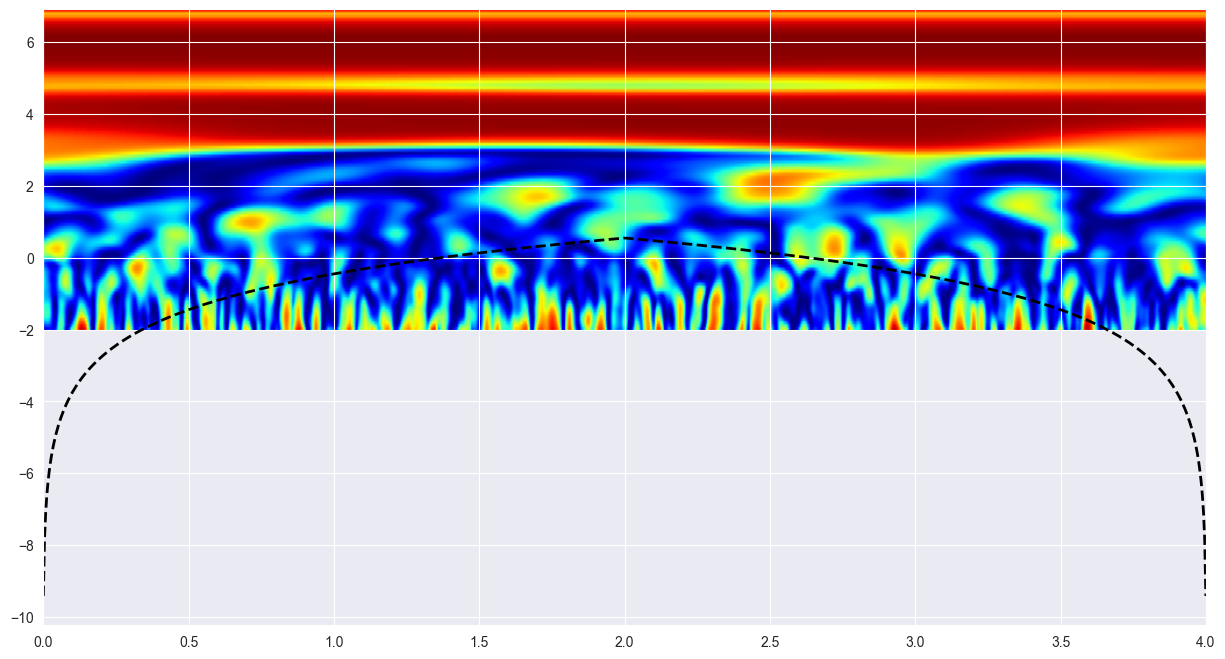

In [5]:
def plot_wavelet_coherence_spectrum(time, freq, WCT, coi, sig, 
                                  title="Wavelet Coherence Spectrum"):
    """
    Wavelet coherence 스펙트럼 시각화
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 시간-주파수 범위 설정
    extent = [time.min(), time.max(), np.log2(freq.min()), np.log2(freq.max())]
    
    # Coherence 스펙트럼 플롯
    im = ax.imshow(np.abs(WCT), extent=extent, cmap='jet', aspect='auto', 
                   origin='lower', vmin=0, vmax=1)
    
    # Cone of influence 표시
    ax.plot(time, np.log2(coi), 'k--', linewidth=2, label='Cone of Influence')
    
    # 유의성 레벨 컨투어
    ax.contour(time, np.log2(freq), sig, levels=[1], colors='white', 
               linewidths=2, linestyles='solid')
    
    # 컬러바 추가
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Wavelet Coherence', fontsize=12)
    
    # 축 레이블 및 제목
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('log₂(Period)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Y축 눈금 설정 (주기로 표시)
    yticks = np.arange(np.ceil(np.log2(freq.min())), 
                      np.floor(np.log2(freq.max())) + 1)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{2**int(y)}' for y in yticks])
    
    # 범례 추가
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

# 스펙트럼 시각화
fig, ax = plot_wavelet_coherence_spectrum(time, freq, WCT, coi, sig)
